# Daily Average Temperature Calculation

In [13]:
# ---- Package Installation and Loading ----
# Ensure required packages are installed and loaded
required_packages <- c("dplyr", "lubridate")
installed_packages <- rownames(installed.packages())
for (pkg in required_packages) {
    if (!pkg %in% installed_packages) {
        install.packages(pkg, dependencies = TRUE)
    }
    library(pkg, character.only = TRUE)
}

# ---- Data Reading ----
# read the daily measurement file (CSV)
temp_data <- read.csv("../data/FLX_CH-Oe2_FLUXNET2015_FULLSET_2004-2023_1-3/FLX_CH-Oe2_FLUXNET2015_FULLSET_DD_2004-2023_1-3.csv")


# filter data for temperature variables
temp_data <- temp_data %>%
    select(TIMESTAMP, TA_F_MDS_DAY) # according to fluxdatakit
head(temp_data)

# ---- Timestamp Conversion ----
# convert TIMESTAMP to Date type yyyy-mm-dd from YYYYMMDD format
temp_data$TIMESTAMP <- as.Date(as.character(temp_data$TIMESTAMP), format = "%Y%m%d")
# rename columns for clarity
colnames(temp_data) <- c("date", "temp")
head(temp_data)

# read the half-hourly measurement file (CSV) and filter
# Read half-hourly data for tmin and tmax calculation
temp_hh_data <- read.csv("../data/FLX_CH-Oe2_FLUXNET2015_FULLSET_2004-2023_1-3/FLX_CH-Oe2_FLUXNET2015_FULLSET_HH_2004-2023_1-3.csv")

# Convert TIMESTAMP_START to character and extract date
temp_hh_data$TIMESTAMP_START <- as.character(temp_hh_data$TIMESTAMP_START)
temp_hh_data$date <- as.Date(substr(temp_hh_data$TIMESTAMP_START, 1, 8), format = "%Y%m%d")

# Calculate daily min and max temperatures
temp_minmax <- temp_hh_data %>%
    group_by(date) %>%
    summarise(
        tmin = min(TA_F, na.rm = TRUE),
        tmax = max(TA_F, na.rm = TRUE)
    ) %>%
    ungroup()

# Merge with existing daily temperature data
temp_data <- temp_data %>%
    left_join(temp_minmax, by = "date")

head(temp_data)  # Preview the first few rows of the final dataset
write.csv(temp_data, "../data/01_data_prep/01_temp_tmin_tmax.csv", row.names = FALSE)

,TIMESTAMP,TA_F_MDS_DAY
,<int>,<dbl>
1,20040101,-0.227
2,20040102,-0.499
3,20040103,-2.956
4,20040104,-4.209
5,20040105,-1.192
6,20040106,-1.580


,date,temp
,<date>,<dbl>
1,2004-01-01,-0.227
2,2004-01-02,-0.499
3,2004-01-03,-2.956
4,2004-01-04,-4.209
5,2004-01-05,-1.192
6,2004-01-06,-1.580


,date,temp,tmin,tmax
,<date>,<dbl>,<dbl>,<dbl>
1,2004-01-01,-0.227,-1.23,-0.01
2,2004-01-02,-0.499,-2.06,-0.05
3,2004-01-03,-2.956,-5.82,-2.19
4,2004-01-04,-4.209,-10.45,-1.48
5,2004-01-05,-1.192,-8.10,0.53
6,2004-01-06,-1.580,-7.24,0.35


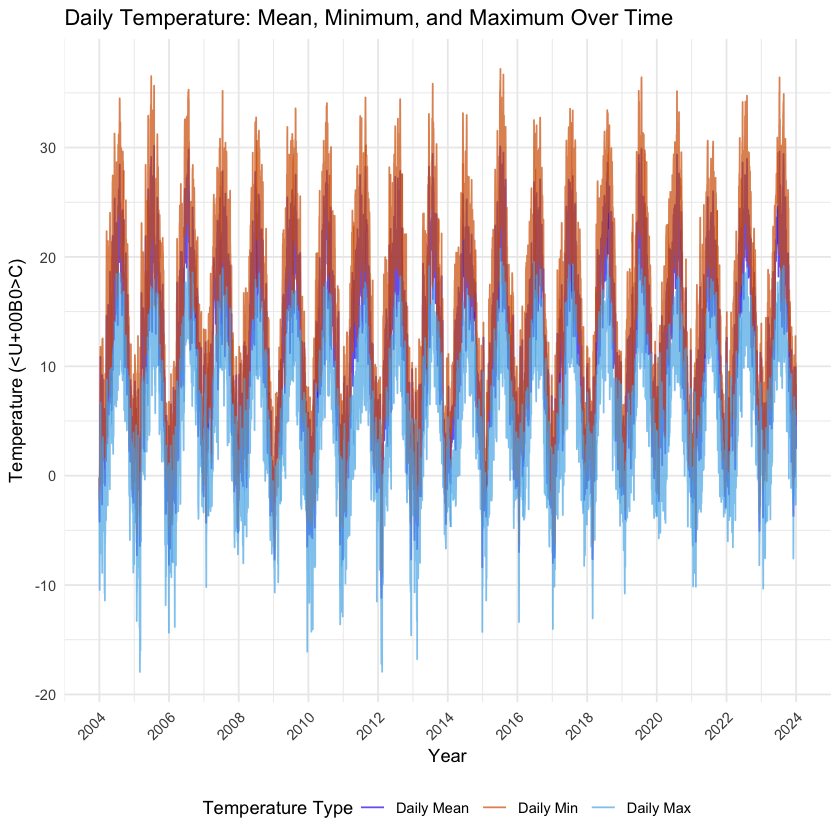

In [17]:
# Load ggplot2 for plotting
library(ggplot2)
library(tidyr)

# Add year column for plotting
temp_data$year <- year(temp_data$date)

# Reshape data to long format for plotting daily mean, min, and max
temp_long <- temp_data %>%
    select(date, year, temp, tmin, tmax) %>%
    pivot_longer(cols = c(temp, tmin, tmax), 
                 names_to = "temp_type", 
                 values_to = "temp_value")

# Create first plot with contrasting colors using a palette
plot1 <- ggplot(temp_long, aes(x = date, y = temp_value, color = temp_type)) +
    geom_line(alpha = 0.7, linewidth = 0.5) +
    scale_color_manual(values = c("temp" = "#3200e6", 
                                "tmin" = "#56B4E9", 
                                "tmax" = "#D55E00"),
                      labels = c("Daily Mean", "Daily Min", "Daily Max")) +
    scale_x_date(date_labels = "%Y", date_breaks = "2 years") +
    labs(title = "Daily Temperature: Mean, Minimum, and Maximum Over Time",
         x = "Year",
         y = "Temperature (°C)",
         color = "Temperature Type") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")

# Display the plot
print(plot1)

# Create the directory for trend plots if it does not exist
if (!dir.exists("../data/01_data_prep/trend_plots")) {
    dir.create("../data/01_data_prep/trend_plots", recursive = TRUE)
}

# Save the plot as a PNG file
ggsave("../data/01_data_prep/trend_plots/01a_temperature_comparison_plot.png", plot = plot1, width = 12, height = 6, bg = "white", dpi = 300)
